# circle dataのQSVMによる分類

#### このコードでは，初期エンコード回路，初期エンコード関数を用いたQSVMによってcircle dataの分類を行った．

## qiskitのインポート

In [1]:
pip install qiskit==0.19.2

     |████████████████████████████████| 6.7MB 11.4MB/s 
     |████████████████████████████████| 23.4MB 55.3MB/s 
     |████████████████████████████████| 163kB 53.3MB/s 
     |████████████████████████████████| 174kB 40.8MB/s 
     |████████████████████████████████| 1.9MB 50.0MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 5.9MB 41.4MB/s 
     |████████████████████████████████| 1.3MB 46.7MB/s 
     |████████████████████████████████| 194kB 51.2MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 614kB 40.0MB/s 
     |████████████████████████████████| 29.5MB 162kB/s 
     |████████████████████████████████| 2.6MB 48.5MB/s 
  Created wheel for qiskit: filename=qiskit-0.19.2-cp36-none-any.whl size=2894 sha256=022316d1f0f0683898720456237a50c826d42c70224f46717aac5d6b55209d6f
  Stored in directory: /root/.cache/pip/wheels/d8/29/6e/e065f721b42fe7

## ライブラリの取得

In [2]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from tqdm.notebook import tqdm  

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance
from qiskit.ml.datasets import ad_hoc_data, breast_cancer
from qiskit.aqua import aqua_globals
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.algorithms import SklearnSVM
from qiskit.aqua.algorithms import QSVM
from qiskit.circuit.library import ZZFeatureMap

## データや量子回路の設定

#### ここでは，実験における訓練データ，テストデータの個数の設定，特徴量の個数，分類・予測結果を表示するグラフの設定などを行う

In [3]:
# 訓練・テストデータの設定
feature_dim = 2  # 特徴量の数
training_dataset_size = 20
testing_dataset_size = 10

# 予測データの設定
size = 50  # 50x50のメッシュを分類によって色分けし、擬似的に境界面を可視化する
mesh_list = [[2*i/size-1, 2*j/size-1] for i in range(size+1) for j in range(size+1)]

# 量子コンピュータのパラメータ設定
shots = 1024
seed = 10598

## ヒートマップ
#### ここでは，分類・予測結果を図示するためのヒートマップを導入する．

In [4]:
def heatmap(pred_list, size=50):
    mat = np.flipud(pred_list.reshape(size+1, size+1, order='F'))
    centers = [-1, 1, -1, 1]
    dx, = np.diff(centers[:2])/(size)
    dy, = -np.diff(centers[2:])/(size)
    extent = [centers[0]-dx/3, centers[1]+dx/3, centers[2]+dy/3, centers[3]-dy/3]
    cmap = mpl.colors.ListedColormap(['orange', 'cyan'])
    # ヒートマップ表示
    plt.imshow(mat, interpolation='nearest', vmin=0, vmax=1, cmap=cmap, extent=extent)


def scatter_data(train_for_pred, test_for_pred, train_result, test_result,
                 yshift=-0.155, print_index=False):
    dataset_dict = {"train": train_for_pred, "test": test_for_pred}
    result_dict = {"train":train_result, "test":test_result}
    marker_dict = {"train": "o", "test": "s"}

    for data_type in ["train", "test"]:
        data_num_half = int(len(dataset_dict[data_type])/2) # ラベルA/Bのデータ数が1:1と仮定とする
        for label in ["A", "B"]:  
            if label == "A":
                (plot_data, color) = dataset_dict[data_type][:data_num_half], "red"
            elif label == "B":
                (plot_data, color) = dataset_dict[data_type][data_num_half:], "blue"
            plt.plot(plot_data[:,0], plot_data[:,1], marker_dict[data_type], color=color, markersize=10)

        # 誤分類を×マークでプロット
        for i, pred_label in enumerate(result_dict[data_type]):
            if (i < data_num_half and pred_label != 0)\
              or (i >= data_num_half and pred_label != 1): 
                if print_index:
                    plt.text(dataset_dict[data_type][i][0], dataset_dict[data_type][i][1], str(i), 
                            color="white", size=15, fontweight='bold')
                # ↓ x方向は自動、y方向は手動にてプロットの位置の微調整が現状ベスト
                plt.text(dataset_dict[data_type][i][0], dataset_dict[data_type][i][1] + yshift, "×", 
                         horizontalalignment='center', color="white", size=15, fontweight='bold')
        plt.axis('off')
        plt.title("Classification Boundary", size=15)

## circle data
#### ここでは，60個のサンプルを生成している．

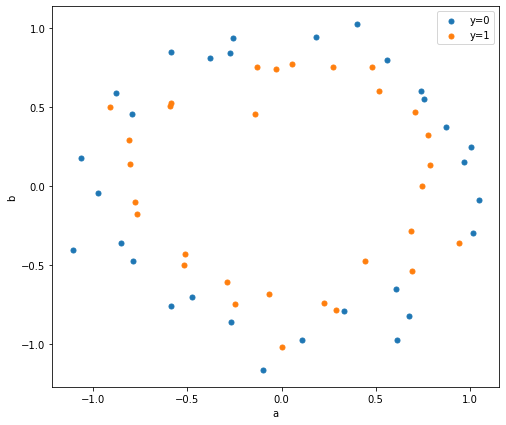

In [34]:
from sklearn import datasets
X, y = datasets.make_circles(60, noise=0.1, random_state=71)

a0, b0 = X[y==0, 0], X[y==0, 1]
a1, b1 = X[y==1, 0], X[y==1, 1]

plt.figure(figsize=(8, 7))
plt.scatter(a0, b0, marker='o', s=25, label='y=0')
plt.scatter(a1, b1, marker='o', s=25, label='y=1')
plt.legend()
plt.xlabel('a')
plt.ylabel('b')
plt.show()

## データの整理
#### ここでは，訓練データ40個を用いて学習し，残りの20個をテストデータとして予測・Accuracyの検証を行う．
#### さらに，ヒートマップのサイズに合わせるため，データを[-1, 1]の範囲に規格化する．

In [47]:
training_input = {'A': X[y==0][0:20], 'B': X[y==1][0:20]}
test_input = {'A': X[y==0][20:30], 'B': X[y==1][20:30]}

#(-1, 1)でプロットするためにdatasetを規格化
(train_for_pred, _), _ = split_dataset_to_data_and_labels(training_input)
(test_for_pred, _), _ = split_dataset_to_data_and_labels(test_input)
dataset_array = np.vstack([train_for_pred, test_for_pred])
min_array, max_array = dataset_array.min(), dataset_array.max()
training_input_normalized = {k:(v-min_array)/(max_array-min_array)*2-1 for k,v in training_input.items()}
test_input_normalized = {k:(v-min_array)/(max_array-min_array)*2-1 for k,v in test_input.items()} 
(train_for_pred, _), _ = split_dataset_to_data_and_labels(training_input_normalized)
(test_for_pred, _), _ = split_dataset_to_data_and_labels(test_input_normalized)

# 特徴マップ
#### ここでは，本実験で用いた３つのエンコード回路・エンコード関数の組により構築される特徴マップを導入する．

### 1. 初期エンコード回路＋初期エンコード関数

####  既存APIのZZfeaturemapで実装可能

In [37]:
feature_map1 = ZZFeatureMap(feature_dim, reps=2)

### 2. エンコード回路１

#### 対応するエンコード関数は論文に示してある．

In [15]:
from qiskit.aqua.components.feature_maps import FeatureMap
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import BlueprintCircuit
import math

#特徴マップの名前をCustomFeatureMapとする．
#初期値の設定
class CustomFeatureMap(FeatureMap):

    
    def __init__(self, feature_dimension, depth=2, entangler_map=None):

        self._support_parameterized_circuit = False
        self._feature_dimension = feature_dimension
        self._num_qubits = self._feature_dimension = feature_dimension
        self._depth = depth
        self._entangler_map = None
        if self._entangler_map is None:
            self._entangler_map = [[i, j] for i in range(self._feature_dimension) for j in range(i + 1, self._feature_dimension)]
    
    # 回路の構築
    def construct_circuit(self, x, qr, inverse=False):

        qc = QuantumCircuit(qr)

        for _ in range(self._depth):


            qc.h(qr[0])
            qc.h(qr[1])

            qc.rx(x[0], qr[0])
            qc.rx(x[1], qr[1])

            qc.cx(qr[0], qr[1])
            qc.ry(np.pi * x[0] * x[1], qr[1])
            qc.cx(qr[0], qr[1])
                    
        if inverse:
            qc.inverse()
        return qc

### 3. エンコード回路２

#### 対応するエンコード関数は論文に示してある．

In [51]:
from qiskit.aqua.components.feature_maps import FeatureMap
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import BlueprintCircuit
import math

class CustomFeatureMap(FeatureMap):

    
    def __init__(self, feature_dimension, depth=2, entangler_map=None):

        self._support_parameterized_circuit = False
        self._feature_dimension = feature_dimension
        self._num_qubits = self._feature_dimension = feature_dimension
        self._depth = depth
        self._entangler_map = None
        if self._entangler_map is None:
            self._entangler_map = [[i, j] for i in range(self._feature_dimension) for j in range(i + 1, self._feature_dimension)]
            
    def construct_circuit(self, x, qr, inverse=False):

        qc = QuantumCircuit(qr)

        
        for _ in range(self._depth):


            
            qc.h(qr[0])
            qc.h(qr[1])
            
            qc.ry(x[0], qr[0])
            qc.ry(x[1], qr[1])
            
            qc.cx(qr[0], qr[1])
            qc.rz(np.cos(x[0]) * np.cos(x[1]), qr[1])
            qc.cx(qr[0], qr[1])
                    
        if inverse:
            qc.inverse()
        return qc

## 結果

### 1. 初期エンコード回路を用いて分類・予測し，Accuracyを示す．

In [39]:
backend = BasicAer.get_backend('qasm_simulator')
svm = QSVM(feature_map1, training_input_normalized, test_input_normalized, None)# the data for prediction can be fed later.
random_seed = 71
svm.random_seed = random_seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=random_seed, seed_transpiler=random_seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.75


### 2. エンコード回路１を用いて分類・予測し，Accuracyを示す．

In [40]:
backend = BasicAer.get_backend('qasm_simulator')
feature_map2 = CustomFeatureMap(feature_dimension=2, depth=2)
svm = QSVM(feature_map2, training_input_normalized, test_input_normalized)  # the data for prediction can be fed later.
svm.random_seed = 71
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
                The <class '__main__.CustomFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  This is separate from the ipykernel package so we can avoid doing imports until


testing success ratio:  0.7


### 3. エンコード回路２を用いて分類・予測し，Accuracyを示す．

In [53]:
backend = BasicAer.get_backend('qasm_simulator')
feature_map3 = CustomFeatureMap(feature_dimension=2, depth=2)
svm = QSVM(feature_map3, training_input_normalized, test_input_normalized) 
svm.random_seed = 71
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
                The <class '__main__.CustomFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  This is separate from the ipykernel package so we can avoid doing imports until


testing success ratio:  0.9


## ヒートマップの表示

#### ここでは例として，初期エンコード回路を用いた場合ヒートマップを表示する．

#### 1, 初めに，学習済みモデルを使って，$[-1,1]*[-1,1]$の各点におけるラベル予測をする．

In [23]:

(iter_num, input_size) = (51*3, 17)
mesh_list_iter = np.array(mesh_list).reshape(iter_num, input_size, feature_dim)

mesh_predict_tmp = []
for i, iter_list in enumerate(tqdm(mesh_list_iter)):
    tmp_list = svm.predict(iter_list)
    mesh_predict_tmp.append(tmp_list)
    print("epoch ", i, " has done ",list(tmp_list))

mesh_predict_result = np.array(mesh_predict_tmp).reshape(-1)

epoch  0  has done  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
epoch  1  has done  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
epoch  2  has done  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
epoch  3  has done  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
epoch  4  has done  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
epoch  5  has done  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
epoch  6  has done  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
epoch  7  has done  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
epoch  8  has done  [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
epoch  9  has done  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
epoch  10  has done  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0]
epoch  11  has done  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
epoch  12  has done  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
epoch  13  has done  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 

#### 2, 次に，同様のモデルを使って，もともとの訓練データとテストデータのラベルを予測する．

In [48]:
train_result = svm.predict(train_for_pred)
test_result = svm.predict(test_for_pred)

#### 3, 最後に，以上の点をプロットしたヒートマップを表示する．

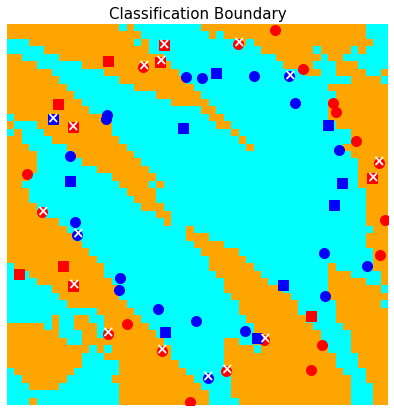

In [49]:
mesh_predict_result = np.array(mesh_predict_tmp).reshape(-1)
plt.figure(figsize=(7, 7))               
heatmap(mesh_predict_result)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.014)
plt.show()

#### 参考文献
#### qiita. 「Qiskitで量子SVMを実装して性能評価してみた」.
#### https://qiita.com/ucc_white/items/f2ea0d019979dd675f82（参照2021-01-04）